In [1]:
from google.colab import files
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
!pip install squarify
import squarify
uploaded = files.upload()

Saving Dataset.xlsx to Dataset.xlsx


In [2]:
orders = pd.read_excel("Dataset.xlsx")
orders

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Channel,Postal Code,Product ID,Sales,Quantity,Unit Cost
0,646,CA-2017-126221,2017-12-30,2018-01-05,Standard Class,CC-12430,Home Office,47201,OFF-AP-10002457,209.300,2,76.3945
1,907,CA-2017-143259,2017-12-30,2018-01-03,Standard Class,PO-18865,Consumer,10009,FUR-BO-10003441,323.136,4,77.7546
2,908,CA-2017-143259,2017-12-30,2018-01-03,Standard Class,PO-18865,Consumer,10009,TEC-PH-10004774,90.930,7,12.6003
3,909,CA-2017-143259,2017-12-30,2018-01-03,Standard Class,PO-18865,Consumer,10009,OFF-BI-10003684,52.776,3,10.9950
4,1297,CA-2017-115427,2017-12-30,2018-01-03,Standard Class,EB-13975,Corporate,94533,OFF-BI-10002103,13.904,2,4.6926
...,...,...,...,...,...,...,...,...,...,...,...,...
9989,1760,CA-2014-141817,2014-01-05,2014-01-12,Standard Class,MB-18085,Consumer,19143,OFF-AR-10003478,19.536,3,4.8840
9990,740,CA-2014-112326,2014-01-04,2014-01-08,Standard Class,PO-19195,Home Office,60540,OFF-LA-10003223,11.784,3,2.5041
9991,741,CA-2014-112326,2014-01-04,2014-01-08,Standard Class,PO-19195,Home Office,60540,OFF-ST-10002743,272.736,3,112.5036
9992,742,CA-2014-112326,2014-01-04,2014-01-08,Standard Class,PO-19195,Home Office,60540,OFF-BI-10004094,3.540,2,4.5135


In [3]:
returned = pd.read_excel("Dataset.xlsx",sheet_name="Return")
df= orders.merge(returned,how='left',on='Order ID')
# Xóa các hàng dựa trên điều kiện
df = df.drop(df[df['Returned'] == "Yes"].index)
# Tạo bảng timedata để tính ngày đặt hàng gần nhất
timedata = df.groupby(['Customer ID']).agg(Ordernearest=('Order Date', 'max')).reset_index()
timedata = timedata.assign(NewColumn="2017-12-31")
timedata['NewColumn'] = pd.to_datetime(timedata['NewColumn'])
timedata['R']= (timedata['NewColumn']-timedata['Ordernearest']).dt.days

In [4]:
# Tính F = total order ID
a= df.groupby('Customer ID').agg(F=('Order ID', 'nunique')).reset_index()

In [5]:
# Tính M = sum sales theo customer ID
b= df.groupby('Customer ID').agg(M=('Sales', 'sum')).reset_index()

In [6]:
# tạo bảng rfm với rfm_score theo customer ID
rf = pd.merge(timedata, a, on='Customer ID')
rfm = pd.merge(rf, b, on='Customer ID')
rfm = rfm.drop(['Ordernearest','NewColumn'], axis=1)
r_labels,f_labels,m_labels =range(5,0,-1),range(1,6),range(1,6)
rfm['r_score']=pd.qcut(rfm['R'],q=5,labels=r_labels)
rfm['f_score']=pd.qcut(rfm['F'],q=5,labels=f_labels)
rfm['m_score']=pd.qcut(rfm['M'],q=5,labels=m_labels)
rfm['rfm_score']= rfm['r_score'].astype(str) + rfm['f_score'].astype(str) + rfm['m_score'].astype(str)
rfm['rfm_score']=rfm['rfm_score'].astype(int)
rfm.head()

,Customer ID,R,F,M,r_score,f_score,m_score,rfm_score
0,AA-10315,185,5,5563.560,2,2,5,225
1,AA-10375,20,9,1056.390,5,5,2,552
2,AA-10480,260,4,1790.512,2,1,3,213
3,AA-10645,483,5,5073.975,1,2,5,125
4,AB-10015,416,3,886.156,1,1,2,112


In [7]:
# tách bảng segmentation
seg=pd.read_excel('Dataset.xlsx',sheet_name='Segmentation')
seg.columns=[col.lower().replace(' ','_') for col in seg.columns]
seg['rfm_score']=seg['rfm_score'].str.split(',')
seg=seg.explode('rfm_score').reset_index(drop=True)
seg['rfm_score']=seg['rfm_score'].astype(int)
seg.sort_values(by='rfm_score',ascending=False)

,segment,rfm_score
0,Champions,555
1,Champions,554
15,Potential Loyalist,553
17,Potential Loyalist,552
16,Potential Loyalist,551
...,...,...
105,Cannot Lose Them,115
106,Cannot Lose Them,114
107,Cannot Lose Them,113
120,Lost customers,112


In [8]:
# merge bảng customer ID với segment
customer = rfm.merge(seg,on='rfm_score',how='left')
customer

,Customer ID,R,F,M,r_score,f_score,m_score,rfm_score,segment
0,AA-10315,185,5,5563.560,2,2,5,225,At Risk
1,AA-10375,20,9,1056.390,5,5,2,552,Potential Loyalist
2,AA-10480,260,4,1790.512,2,1,3,213,About To Sleep
3,AA-10645,483,5,5073.975,1,2,5,125,At Risk
4,AB-10015,416,3,886.156,1,1,2,112,Lost customers
...,...,...,...,...,...,...,...,...,...
786,XP-21865,83,9,2110.726,3,5,3,353,Potential Loyalist
787,YC-21895,5,4,5438.650,5,1,5,515,Promising
788,YS-21880,10,8,6720.444,5,4,5,545,Champions
789,ZC-21910,55,12,7892.998,4,5,5,455,Champions


In [9]:
#data để vẽ chart
seg = customer.groupby('segment').agg(count_cus=('Customer ID','count')
,avg_r=('R','mean')
,avg_f=('F','mean')
,sum_m=('M','sum')).reset_index()
seg

,segment,count_cus,avg_r,avg_f,sum_m
0,About To Sleep,44,135.204545,4.750000,47310.1172
1,At Risk,96,259.041667,7.260417,385996.8861
2,Cannot Lose Them,36,496.527778,4.694444,150229.9414
3,Champions,71,28.521127,9.830986,382096.5868
4,Hibernating customers,90,190.044444,4.733333,109960.2510
5,Lost customers,83,557.963855,2.975904,54264.2255
6,Loyal,62,60.725806,8.161290,270680.2154
7,Need Attention,72,50.138889,6.527778,259412.3922
8,New Customers,61,41.475410,3.393443,40997.1410
9,Potential Loyalist,113,45.185841,7.079646,190944.9303


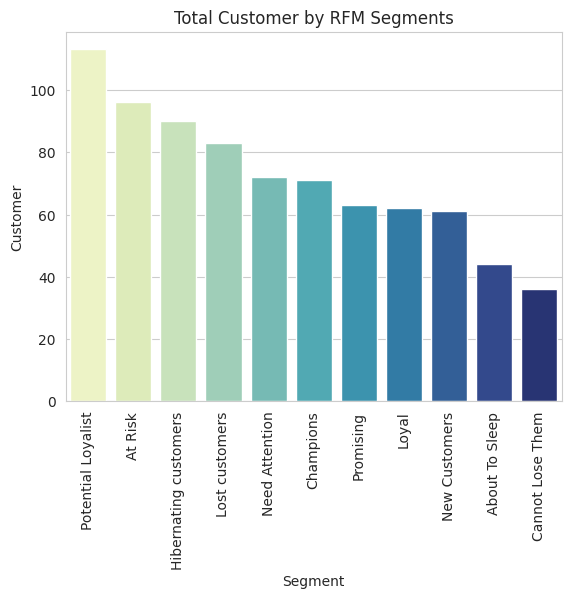

In [10]:
#bar chat tính số customer mỗi segment
sns.set_style("whitegrid")
cus_chart = sns.barplot(x='segment',y='count_cus',data=seg.sort_values('count_cus',ascending=False),palette="YlGnBu")
cus_chart.set_title("Total Customer by RFM Segments")
cus_chart.set(xlabel='Segment',ylabel='Customer')
plt.xticks(rotation=90)
plt.show()


*   Phân khúc Potential Loyalist, At risk chiếm số lượng khách hàng lớn nhất lên đến 113 người và 96 người
*   Phân khúc Cannot Lose Them có số lượng khách hàng ít nhất chỉ với 36 người



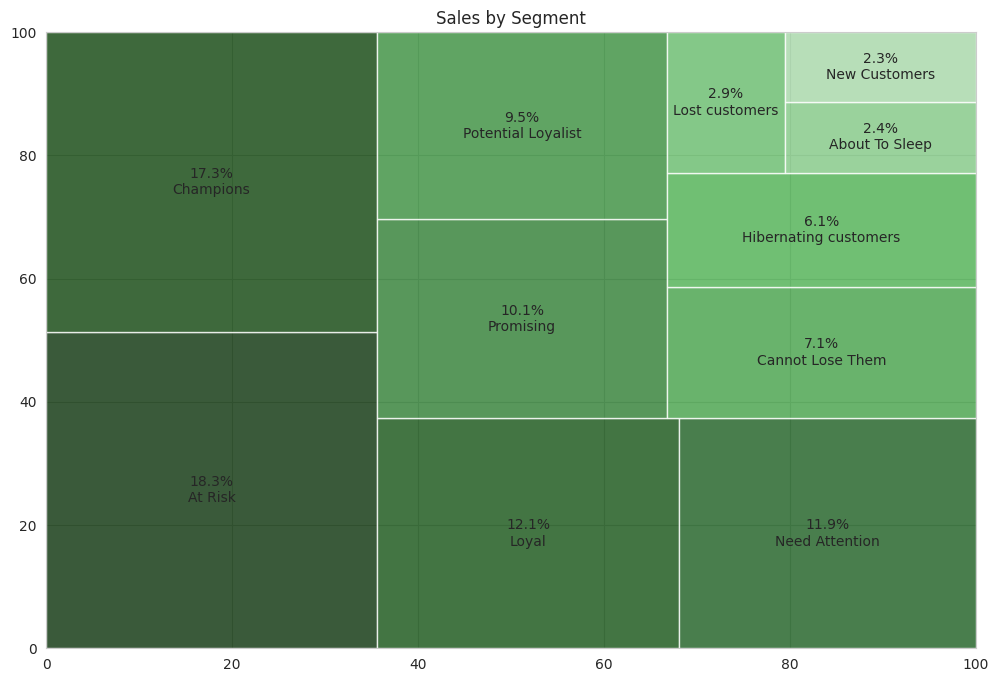

In [39]:
#Groupby sales theo segment
a = customer.merge(orders,on='Customer ID',how='left')
df2= a.groupby('segment')['Sales'].sum().reset_index()
# Sắp xếp dữ liệu theo cột 'percentage'
df2_sorted = df2.sort_values('Sales', ascending=False)
total_sales = df2_sorted['Sales'].sum()
df2_sorted['percentage'] = (df2_sorted['Sales'] / total_sales) * 100
# Tạo treemap total sales theo segment
plt.figure(figsize=(12, 8))
colors = ['#093108', '#0E440B', '#145214', '#1B5E20', '#2E7D32', '#388E3C', '#43A047', '#4CAF50', '#66BB6A', '#81C784', '#A5D6A7']
squarify.plot(sizes=df2_sorted['Sales'],
              label=df2_sorted.apply(lambda x: f'{x["percentage"]:.1f}%\n{x["segment"]}', axis=1),color=colors,
              alpha=0.8)
plt.title('Sales by Segment')
plt.axis('on')
plt.show()




*   Phân khúc khách hàng At Risk và Champions chiếm tỷ trọng doanh thu cao nhất so với các phân khúc khác với tỷ trọng lần lượt là 18.3% và 17.3%
*   Phân khúc khách hàng Lost Customer, About to Sleep, New Customer chiếm tỷ trọng thấp nhất lần lượt là 2.9%, 2.4%, 2.3%



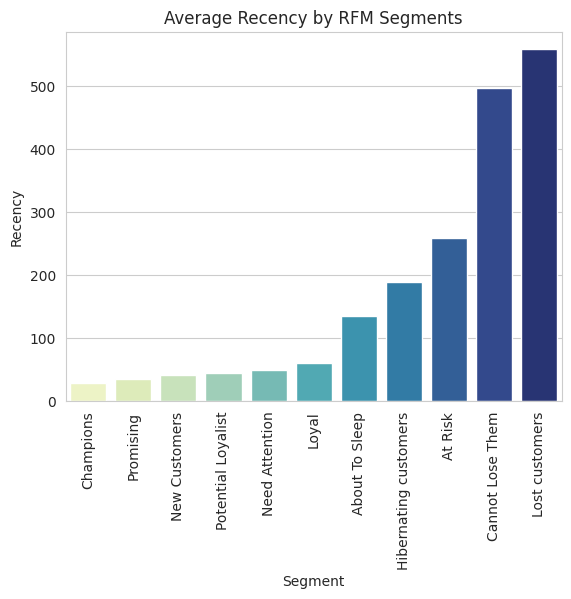

In [29]:
#bar chart average recency theo segment
r_chart = sns.barplot(x='segment',y='avg_r',data=seg.sort_values('avg_r'),palette="YlGnBu")
r_chart.set_title("Average Recency by RFM Segments")
r_chart.set(xlabel='Segment',ylabel='Recency')
plt.xticks(rotation=90)
plt.show()



*   Phân khúc khách hàng Champions có thời gian mua hàng gần đây trung bình nhỏ nhất với giá trị 28.5 ngày, điều này phản ảnh độ gắn bó với công ty của phân khách hàng này
*   Phân khúc khách hàng Lost customers thì đã rất lâu không mua hàng với trung bình gần 558 ngày



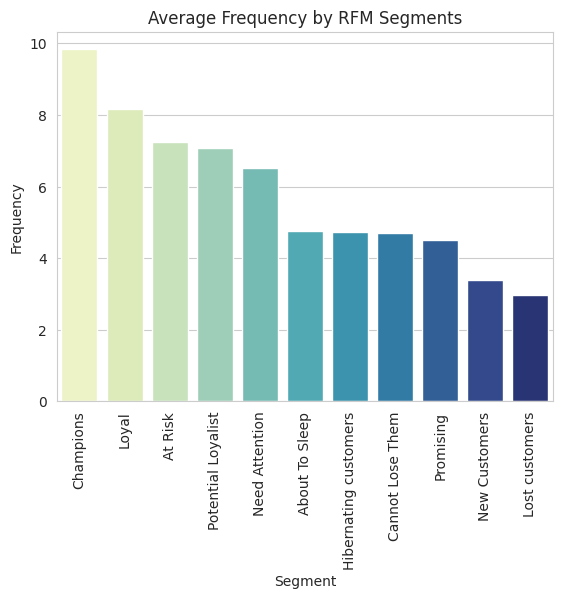

In [30]:
#Frequency
f_chart = sns.barplot(x='segment',y='avg_f',data=seg.sort_values('avg_f',ascending=False),palette="YlGnBu")
f_chart.set_title("Average Frequency by RFM Segments")
f_chart.set(xlabel='Segment',ylabel='Frequency')
plt.xticks(rotation=90)
plt.show()



*   Phân khúc Champions và Loyal có tần suất mua hàng trung bình lớn nhất với lần lượt là 9.8 lần và 8.2 lần mỗi khách hàng
*   Phân khúc Lost customer và New customer thì có tần suất mua hàng trung bình thấp nhất với chỉ 3 lần và 3.4 lần mỗi khách hàng



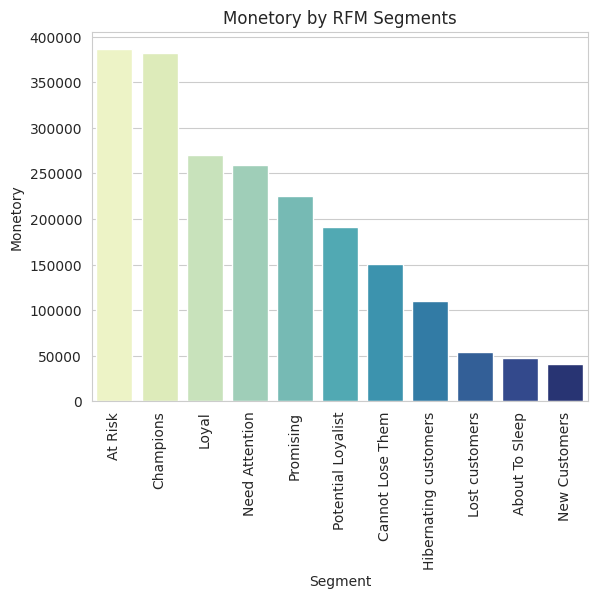

In [31]:
#Monetory
m_chart = sns.barplot(x='segment',y='sum_m',data=seg.sort_values('sum_m',ascending=False),palette="YlGnBu")
m_chart.set_title("Monetory by RFM Segments")
m_chart.set(xlabel='Segment',ylabel='Monetory')
plt.xticks(rotation=90)
plt.show()



*   Phân khúc khách hàng At Risk và Champions có giá trị mỗi lần mua hàng cao nhất so với các phân khúc khác với giá trị lần lượt là 385997 và 382096.6
*   Phân khúc khách hàng About to Sleep, New Customer chiếm tỷ trọng thấp nhất lần lượt là 47310 và 40997



  


---


> Hiện trạng của công ty:
*   Công ty Superstore có các phân khúc khách hàng đa dạng như Potential Loyalist, At Risk, Cannot Lose Them, Champions, Lost Customer, About to Sleep và New Customer.
*   Số lượng khách hàng tập trung nhiều nhất trong các phân khúc Potential Loyalist và At Risk, trong khi phân khúc Cannot Lose Them có số lượng khách hàng ít nhất.
*   Phân khúc khách hàng At Risk và Champions đóng góp tỷ trọng doanh thu cao nhất, cho thấy sự quan trọng của việc tương tác và duy trì mối quan hệ với nhóm này.
*   Tỷ trọng doanh thu của các phân khúc Lost Customer, About to Sleep và New Customer thấp nhất, cho thấy cần đặc biệt chú trọng để thu hút và duy trì khách hàng trong các phân khúc này.





> Gợi ý cho team Marketing
*   Tập trung chiến lược tiếp cận với các phân khúc có lượng khách hàng lớn và doanh thu cao như Potential Loyal, At Risk, Champions, đặc biệt là phân khúc At Risk khi doanh thu phân khúc này lớn và lượng khách hàng cũng nhiều, bằng cách cung cấp ưu đãi và sự tương tác cá nhân hóa để khuyến khích mua hàng và duy trì mối quan hệ với khách hàng trong hai phân khúc này.
*   Phân khúc Champions có giá trị mỗi lần mua hàng cao, team Marketing có thể tạo ra các chương trình gắn kết khách hàng, ưu đãi cho việc mua hàng tiếp theo và khuyến khích khách hàng chia sẻ kinh nghiệm tích cực với công ty.
*   Đối với các phân khúc Lost Customer, About to Sleep và New Customer, tập trung vào việc thu hút và tái kích hoạt khách hàng bằng cách tạo ra chương trình khuyến mãi hấp dẫn và cung cấp trải nghiệm mua hàng tốt hơn.

---


=> Chỉ số nên quan tâm với mô hình bán lẻ của công ty Superstore trong 3 chỉ số R, F, M là chỉ số Monetary (M). Chỉ số Monetary đo tổng giá trị mà khách hàng đã chi tiêu trong một khoảng thời gian nhất định. Team Marketing và Sales nên quan tâm đến chỉ số này để nhận biết khách hàng nào có giá trị cao và đóng góp nhiều vào doanh thu của công ty. Các khách hàng có chỉ số Monetary cao có thể là khách hàng VIP hoặc doanh nghiệp đối tác quan trọng. Team có thể tập trung vào việc xây dựng quan hệ chặt chẽ, cung cấp dịch vụ tốt hơn và đề xuất các giao dịch hoặc sản phẩm cao cấp hơn cho nhóm khách hàng này.




